
<h1 align="center">Women's E-Commerce Clothing Reviews</h1>
<h3 align="center">23,000 Customer Reviews and Ratings</h3>


#### Contexto

Este é um conjunto de dados é de um E-Commerce de Roupas Femininas que gira em torno das avaliações escritas pelos clientes. Seus nove recursos de suporte oferecem um ótimo ambiente para analisar o texto através de suas múltiplas dimensões. Por se tratar de dados comerciais reais, eles foram anonimizados e as referências à empresa no texto e no corpo da revisão foram substituídas por "varejista".
  
#### Conteúdo
Este conjunto de dados inclui 23486 linhas e 10 variáveis de recursos. Cada linha corresponde a uma revisão do cliente e inclui as variáveis:

* **ID da roupa:** Integer Variável categórica que se refere à peça específica que está sendo revisada.
* **Idade:** Positiva Variável inteira da idade dos revisores.
* **Título:** variável de string para o título da revisão.
* **Rever texto:** variável de string para o corpo de revisão.
* **Classificação:** Variável Integral Positiva Positiva para a pontuação do produto concedida pelo cliente de 1 pior, a 5 melhores.
* **IND recomendado:** Variável binária indicando onde o cliente recomenda o produto, em que 1 é recomendado, 0 não é recomendado.
* **Contagem de Feedback Positivo:** Integral Positivo documentando o número de outros clientes que consideraram este comentário positivo.
* **Nome da Divisão:** Nome categórico da divisão de alto nível do produto.
* **Nome do departamento:** nome categórico do nome do departamento do produto.
* **Nome da Classe:** nome categórico do nome da classe do produto.



## Importe das bibliotecas necessárias.

In [105]:
# Bibliotecas importadas.
import numpy as np
import pandas as pd
import nltk
import random
import os
from os import path
from PIL import Image

# Bibliotecas de visualização
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

# Paleta de cores dos gráficos
sns.set_palette([
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",
])

# Pré-Processo
import string
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re
from nltk.stem import PorterStemmer

# Modelagem
import statsmodels.api as sm
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk.util import ngrams
from collections import Counter
from gensim.models import word2vec

# Avisos
import warnings
warnings.filterwarnings('ignore')

In [106]:
# Ler e dropar a primeira coluna e salvar as alterações no data set.
df = pd.read_csv("Womens Clothing E-Commerce Reviews.csv")
df.drop(df.columns[0],inplace=True, axis=1)

# Deletar observações ausentes para as seguintes variáveis.
for x in ["Division Name","Department Name","Class Name","Review Text"]:
    df = df[df[x].notnull()]

# Extraindo Contagem Ausente e Contagem Única por Coluna
unique_count = []
for x in df.columns:
    unique_count.append([x,len(df[x].unique()),df[x].isnull().sum()])

# Mostrar a quantidade de Missing Values.
print("Missing Values: {}".format(df.isnull().sum().sum()))

# Mostrar a dimensão do Data set.
print("Dataframe Dimension: {} Rows, {} Columns".format(*df.shape))

# Criando novas variáveis: 
# comprimento das palavas
df["Word Count"] = df['Review Text'].str.split().apply(len)
# comprimento do personagem
df["Character Count"] = df['Review Text'].apply(len)
# Aplicando o booleano Positivo ou negativo para os Reviews
df["Label"] = 0
df.loc[df.Rating >= 3,["Label"]] = 1

Missing Values: 2966
Dataframe Dimension: 22628 Rows, 10 Columns


In [121]:
df.head(1)

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Word Count,Character Count,Label,Age_rec,Age_2
0,767,33,NaN,Absolutely wonderful - silky and sexy and comfortable,4,1,0,Initmates,Intimate,Intimates,8,53,1,31-40,"(25, 35]"


Depois de ler os dados, uma variável binária foram criada para melhor o entendimento a classificação em avaliações "boas" e "ruins". 
Há valores ausentes em falta, que deixarei por enquanto, já que eles podem fornecer informações extras tralvez utilizáveis.

## EDA

Para começar a minha análise, preciso saber como está a distribuição do meu data set, identificando assim quantos valores ausêntes possuo em cada coluna.

In [157]:
pd.DataFrame(unique_count, columns=["Column","Unique","Missing"]).set_index("Column").T

Column,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
Unique,1172,77,13984,22621,5,2,82,3,6,20
Missing,0,0,2966,0,0,0,0,0,0,0


* Existem aproximadamente 3000 valores ausentes, o que representa 1% do conjunto de dados, esses dados nnao seram excluidos.
* Entre as variáveis categóricas, exigirá métodos exploratórios não-visuais, como os apresentados abaixo, utilizando a função describe.

In [111]:
df.describe().T.drop("count",axis=1).T

,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count,Word Count,Character Count,Label
mean,919.695908,43.282880,4.183092,0.818764,2.631784,60.211950,308.761534,0.895263
std,201.683804,12.328176,1.115911,0.385222,5.787520,28.533053,143.934126,0.306222
min,1.000000,18.000000,1.000000,0.000000,0.000000,2.000000,9.000000,0.000000
25%,861.000000,34.000000,4.000000,1.000000,0.000000,36.000000,186.000000,1.000000
50%,936.000000,41.000000,5.000000,1.000000,1.000000,59.000000,302.000000,1.000000
75%,1078.000000,52.000000,5.000000,1.000000,3.000000,88.000000,459.000000,1.000000
max,1205.000000,99.000000,5.000000,1.000000,122.000000,115.000000,508.000000,1.000000


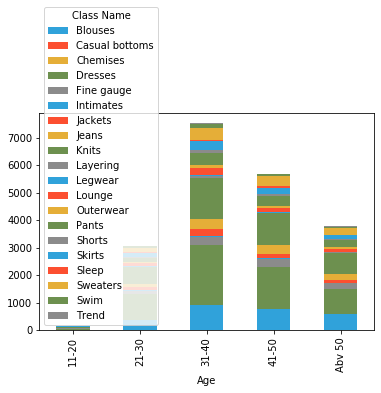

In [156]:
A=df.groupby(['Age','Class Name'])['Age'].count().unstack('Class Name')
A.plot(kind='bar', stacked=True);
#df[['Age','Class Name']].groupby('Age')['Class Name'].sum().plot()

In [138]:
df[['Age','Character Count']].groupby('Age')['Character Count'].describe()

,count,mean,std,min,25%,50%,75%,max
Age,,,,,,,,
0-10,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11-20,149.0,307.241611,133.804549,60.0,185.0,300.0,433.00,502.0
21-30,3070.0,303.162866,139.023643,12.0,187.0,292.0,434.00,505.0
31-40,7542.0,309.719173,143.587481,13.0,188.0,303.0,460.75,504.0
41-50,5700.0,309.084386,144.184207,9.0,187.0,304.0,460.00,507.0
Abv 50,3783.0,302.502247,146.344202,14.0,175.5,290.0,457.50,508.0


In [112]:
df[["Title", "Division Name","Department Name","Class Name"]].describe(include=["O"]).T.drop("count",axis=1)

,unique,top,freq
Title,13983,Love it!,136
Division Name,3,General,13365
Department Name,6,Tops,10048
Class Name,20,Dresses,6145


Partindo para uma exploratória visual, podemos mostrar uma Distribuições de contagem de feedback de idade e positiva, 

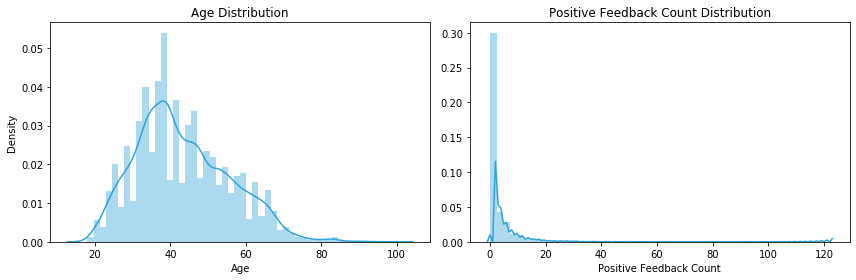

In [113]:
# Distribuição continua
f, ax = plt.subplots(1,2,figsize=(12,4), sharey=False)
sns.distplot(df.Age, ax=ax[0])
ax[0].set_title("Age Distribution")
ax[0].set_ylabel("Density")
sns.distplot(df["Positive Feedback Count"], ax=ax[1])
ax[1].set_title("Positive Feedback Count Distribution")
plt.tight_layout()
plt.show()

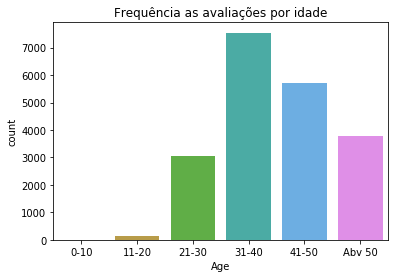

In [137]:
#Para visualizar melhor as idades das mulheres que mais avaliam os produtos.
df['Age'] = pd.cut(df['Age'], [0,10,20,30,40,50,60], labels=['0-10','11-20','21-30','31-40','41-50','Abv 50'])

sns.countplot(x ='Age', data = df);
plt.title('Frequência as avaliações por idade');

**Distribuição de Idade:** 
A principio, pensei que as pessoas que mais deixam reviews quando compra um produtos são jovens de 18 à 34 anos, no entanto essse gráfico mostra que pessoas de 31 à 40 anos, snao os individuos que mais deixam reviews positivos, deixando até 5 reviews 
No entanto, esta tendência de mercado para esta marca de roupa é o das mulheres de 31 à 50 anos. O gráfico apresenta mais ou menos uma normal com pico único e ligeiro crescimento para a cauda direita.

**Distribuição da Contagem de Feedback Positivo:** 
É uma tendência bastante comum em uma distribuição de Feedback Positivo, onde apenas um produto se destaca entre os demais.


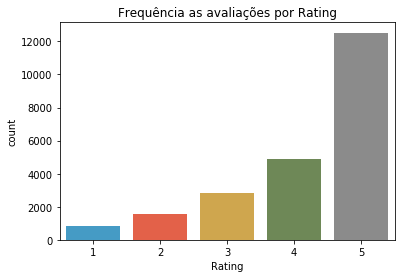

In [9]:
# Plot na quantidade de Rating.
sns.countplot(x = 'Rating', data = df);
plt.title('Frequência as avaliações por Rating');

Variando em uma escala de 1 à 5, onde 5 é uma avaliação boa, podemo ver no gráfico acima que a maioria das avaliaçnoes dos clientes são boas.

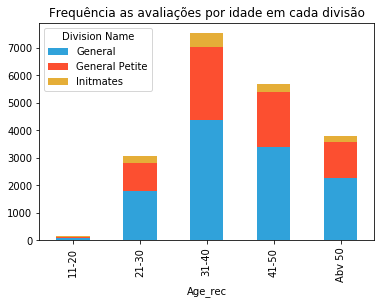

In [133]:
# Agrupamento por idade e nome da divisão, por nome da divisão.
A=df.groupby(['Age','Division Name'])['Age'].count().unstack('Division Name')
A.plot(kind='bar', stacked=True);
plt.title('Frequência as avaliações por idade em cada divisão');

Como apresentado acima, as mulheres entre 31 e 40 anos são as que mais comprar e fazem avaliações dos produtos, ela compram procutos de todas as divisões.

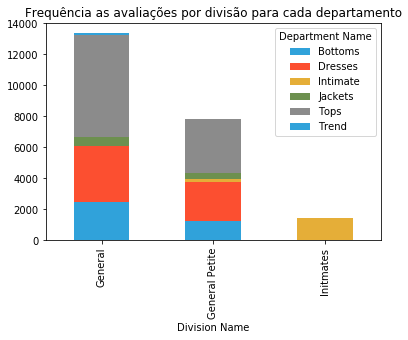

In [11]:
# Agrupamento por nome da divisão por nome do departamento para identificar quais pordutos são mais vendidos em cada divisão.
B= df.groupby(['Division Name', 'Department Name'])['Division Name'].count().unstack('Department Name')
B.plot(kind='bar', stacked=True);
plt.title('Frequência as avaliações por divisão para cada departamento');

Como podemos ver no gráfico acima, a divisão General é a que mais vendem produtos e posteriomente são avaliados, sendo Tops e Dress os itens mais avaliados.  

In [12]:
C = df.groupby(['Division Name','Rating']).size().reset_index()
C.columns = ['Division Name','Rating','Occurence']

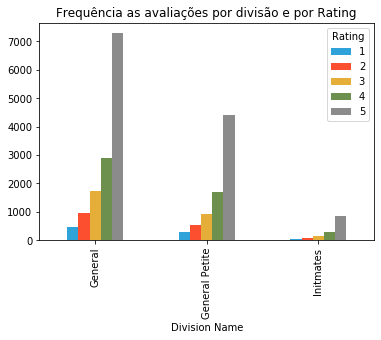

In [13]:
C.pivot(index='Division Name',columns='Rating',values='Occurence').reset_index().plot(kind='bar',x='Division Name')
plt.title('Frequência as avaliações por divisão e por Rating');
plt.show()

O gráfico acima representa os Rating por divisão, confirmando o que vimos nos gráficos anteriores que a divisão General é o que possui mais avaliações e boas.

**Entendendo a popularidade do produto pelo número do ID.**

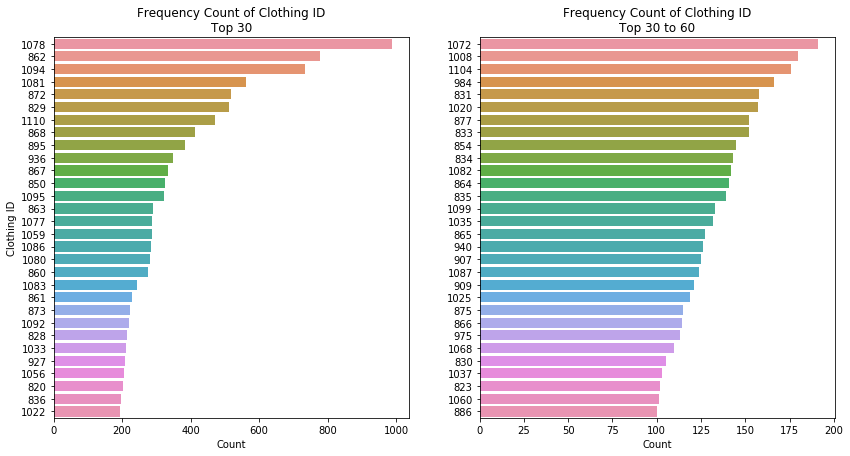

In [14]:
f, axes = plt.subplots(1,2, figsize=[14,7])
num = 30
sns.countplot(y="Clothing ID", data = df[df["Clothing ID"].isin(df["Clothing ID"].value_counts()[:num].index)],
              order= df["Clothing ID"].value_counts()[:num].index, ax=axes[0])
axes[0].set_title("Frequency Count of Clothing ID\nTop 30")
axes[0].set_xlabel("Count")

sns.countplot(y="Clothing ID", data = df[df["Clothing ID"].isin(df["Clothing ID"].value_counts()[num:60].index)],
              order= df["Clothing ID"].value_counts()[num:60].index, ax=axes[1])
axes[1].set_title("Frequency Count of Clothing ID\nTop 30 to 60")
axes[1].set_ylabel("")
axes[1].set_xlabel("Count")
plt.show()

O dataset possui cerca de mil IDs de Roupas, selecionando apenas os 60 itens mais populares.
Existem três produtos que receberam mais avaliações do que outros. Eles são predominantemente vestidos como mostrado no gráfico abaixo.


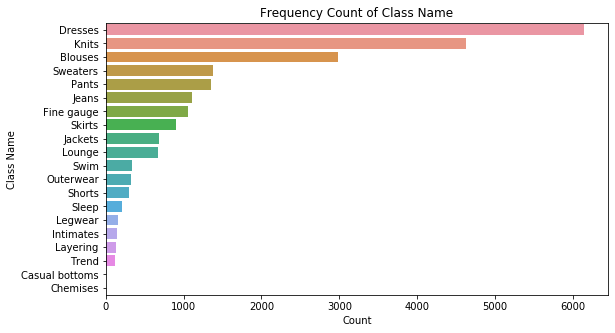

In [15]:
plt.subplots(figsize=(9,5))
sns.countplot(y="Class Name", data=df,order=df["Class Name"].value_counts().index)
plt.title("Frequency Count of Class Name")
plt.xlabel("Count")
plt.show()

In [16]:
df['Class Name'].value_counts()

Dresses           6145
Knits             4626
Blouses           2983
Sweaters          1380
Pants             1350
Jeans             1104
Fine gauge        1059
Skirts             903
Jackets            683
Lounge             669
Swim               332
Outerwear          319
Shorts             304
Sleep              214
Legwear            158
Intimates          147
Layering           132
Trend              118
Casual bottoms       1
Chemises             1
Name: Class Name, dtype: int64

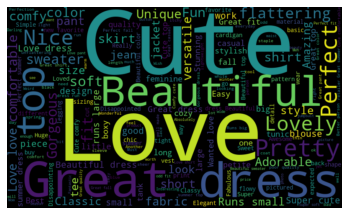

In [17]:
# wordcloud do Título
A=df['Title'].str.cat(sep=' ')
# Create the wordcloud object
wordcloud = WordCloud(width=800, height=480, margin=0).generate(A)
 
# Para gerar o plot:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()


A word cloud acima apresenta as palavras que mais aparecem nos titulos das avaliações dos clientes, Cute, Love, Great, Dress, beautiful...

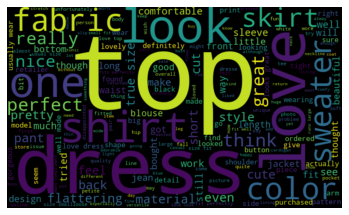

In [18]:
# wordcloud do Review Text
A1=df['Review Text'].str.cat(sep=' ')
# Create the wordcloud object
wordcloud = WordCloud(width=800, height=480, margin=0).generate(A1)
 
# Para gerar o plot:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

A Word cloud acima mostra a palavras que mais aparecem nas avaliações, o interessante é que podemos confimar os intens que mais recebem avaliações tambem são os mais faldos como Dress e Top.

**Padronização da porcentagem para os gráficos de distribuição da recomendação**

A padronização por porcentagem  é utilizada para ver se a proporção é consistente entre classes categóricas.

In [19]:
def percentstandardize_barplot(x,y,hue, data, ax=None, order= None):
    sns.barplot(x= x, y=y, hue=hue, ax=ax, order=order,
    data=(data[[x, hue]]
     .reset_index(drop=True)
     .groupby([x])[hue]
     .value_counts(normalize=True)
     .rename('Percentage').mul(100)
     .reset_index()
     .sort_values(hue)))
    plt.title("Percentage Frequency of {} by {}".format(hue,x))
    plt.ylabel("Percentage %")

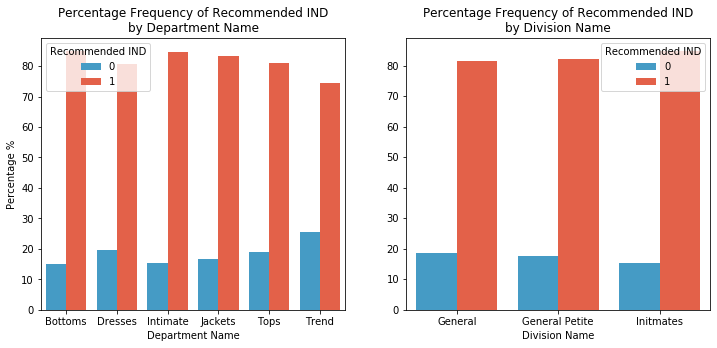

In [20]:
huevar = "Recommended IND"
f, axes = plt.subplots(1,2,figsize=(12,5))
percentstandardize_barplot(x="Department Name",y="Percentage", hue=huevar,data=df, ax=axes[0])
axes[0].set_title("Percentage Frequency of {}\nby Department Name".format(huevar))
axes[0].set_ylabel("Percentage %")
percentstandardize_barplot(x="Division Name",y="Percentage", hue=huevar,data=df, ax=axes[1])
axes[1].set_title("Percentage Frequency of {}\nby Division Name".format(huevar))
axes[1].set_ylabel("")
plt.show()

O gráficos acima mostras a porcentagem padronizada das recomendações positivas representadas pela cor vermelha e pelo número 1, assim como as negativas azuis, representadas pelo número 0, rrelacionadas com os departamentos e as divisões.
Podemos observar que a porcentgem de recomendação com sucesso é significativamente maior que as recomendações que não tiveram sucesso.

## Análise de sentimento

A análise de sentimentos é uma técnica que consiste na extração das informações de textos em linguagem natural. Essa técnica obtem de forma automática, a polaridade de um texto ou sentença. Por exemplo, dada uma sentença, um computador classifica-a como positiva ou negativa. 

**Text Pre-Processing**

In [21]:
pd.set_option('max_colwidth', 500)
df[["Title","Review Text", "Rating"]].head()

,Title,Review Text,Rating
0,NaN,Absolutely wonderful - silky and sexy and comfortable,4
1,NaN,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite.",5
2,Some major design flaws,"I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - ...",3
3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!",5
4,Flattering shirt,This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!,5


In [22]:
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer

ps = PorterStemmer()

tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))

def preprocessing(data):
    txt = data.str.lower().str.cat(sep=' ') 
    words = tokenizer.tokenize(txt) 
    words = [w for w in words if not w in stop_words] 
    
    return words

O código cria uma função que pega cada revisão e as combina em um texto. Em seguida, aplica-se tokenizer minúsculas, transformando todas as palavras para minúsculo, remove stopwords que são as palavras com muita frequência não possui relevancia na análise, retira também a pontuação e usa o PorterStemmer que reduz as palavras ao seu radical, como frequentement reduzindo para frequent. A vantagem é diminuir as palavras da base de dados, ganhando tempo no processamento.

Para entender as avaliações dos clientes é ver como o sentimento textual se relaciona com as pontuações das avaliações. Utilizarei um método, para distinguir comentários positivos e negativos da avaliações.

In [23]:
# Pre-Processo
SIA = SentimentIntensityAnalyzer()
df["Review Text"]= df["Review Text"].astype(str)

# Aplicação do Modelo, Criando variáveis.
df['Polarity Score']=df["Review Text"].apply(lambda x:SIA.polarity_scores(x)['compound'])
df['Neutral Score']=df["Review Text"].apply(lambda x:SIA.polarity_scores(x)['neu'])
df['Negative Score']=df["Review Text"].apply(lambda x:SIA.polarity_scores(x)['neg'])
df['Positive Score']=df["Review Text"].apply(lambda x:SIA.polarity_scores(x)['pos'])

# Converting 0 to 1 Decimal Score to a Categorical Variable
df['Sentiment']=''
df.loc[df['Polarity Score']>0,'Sentiment']='Positive'
df.loc[df['Polarity Score']==0,'Sentiment']='Neutral'
df.loc[df['Polarity Score']<0,'Sentiment']='Negative'

O pré-processamento carrega o módulo Analyzer Intensity Sentiment do NLTK, seleciondo as variáveis desejadas, aplicando as letras minúsculas à coluna de revisões no dataframe. Criando novas colunas para as pontuações positivas, negativas, neutro e de polaridade que mede a diferença entre os valores positivos, negativos e neutro onde os resultados são armazenados em colunas. 
Pontuação Neutra / Negativa / Positiva: Indica a potência dessas classes entre 0 e 1.

**Normalização da plotagens para as distribuições dos sentimentos**

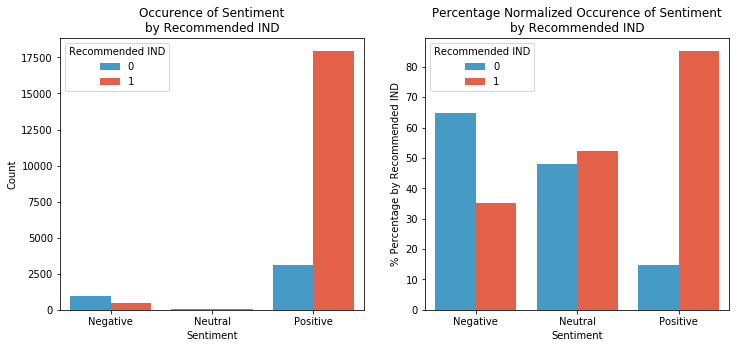

In [24]:
huevar = "Recommended IND"
xvar = "Sentiment"
f, axes = plt.subplots(1,2,figsize=(12,5))
sns.countplot(x=xvar, hue=huevar,data=df, ax=axes[0], order=["Negative","Neutral","Positive"])
axes[0].set_title("Occurence of {}\nby {}".format(xvar, huevar))
axes[0].set_ylabel("Count")
percentstandardize_barplot(x=xvar,y="Percentage", hue=huevar,data=df, ax=axes[1])
axes[1].set_title("Percentage Normalized Occurence of {}\nby {}".format(xvar, huevar))
axes[1].set_ylabel("% Percentage by {}".format(huevar))
plt.show()

Podemos ver no primeiro gráfico da esquerda que à maioria ocorrência de sentimentos positivos são para os intens recomendados e bem avaliados,já no gráfico de normalização da porcentagem a direita, podemos ver que a porcentagem de recomendações positivas segundo a analise de sentimento é maior que 80%, porém a porcentagem de recomendações negativa, segundo a analise de sentimento é bem grande, em torno de 62%. Porém a porcentagem negativa analisando apenas as recomendacões não é tão alta. O motivo iremos entender um puco mais a frente.



In [25]:
stopwords = set(STOPWORDS)
size = (10,7)

def cloud(text, title, stopwords=stopwords, size=size):
    """
    Function to plot WordCloud
    Includes: 
    """
    # Definindo parâmetros de figura
    mpl.rcParams['figure.figsize']=(10.0,10.0)
    mpl.rcParams['font.size']=12
    mpl.rcParams['savefig.dpi']=100
    mpl.rcParams['figure.subplot.bottom']=.1 
    
    # Processando o Texto
    wordcloud = WordCloud(width=1600, height=800,
                          background_color='black',
                          stopwords=stopwords,
                         ).generate(str(text))
    
    # Visualização de saída
    fig = plt.figure(figsize=size, dpi=80, facecolor='k',edgecolor='k')
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=50,color='y')
    plt.tight_layout(pad=0)
    plt.show()
    
# Calculando a frequência 
def wordfreqviz(text, x):
    word_dist = nltk.FreqDist(text)
    top_N = x
    rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
    matplotlib.style.use('ggplot')
    rslt.plot.bar(rot=0)

def wordfreq(text, x):
    word_dist = nltk.FreqDist(text)
    top_N = x
    rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
    return rslt

Função de visualização de nuvem de palavras onde não declara explicitamente que determina a ocorrência de frequência de cada palavra em relação ao dicionário inteiro de palavras. A Setting Function Parameter cria a estrutura gráfica e em seguida, o texto é formatado e a frequência da palavra é determinada, quanto maior o tamanho da palavra, maior a ocorrência da palavra.

In [26]:
department_set = df["Department Name"][df["Department Name"].notnull()].unique()
division_set = df["Division Name"][df["Division Name"].notnull()].unique()
def cloud_by_category(data, category, subclass):
    """
    Function to create a wordcloud by class and subclass
    Category signifies the column variable
    Subclass refers to the specific value within the categorical variable
    """
    new_stop = set(STOPWORDS)
    new_stop.update([x.lower() for x in list(data["Class Name"][data["Class Name"].notnull()].unique())]
                   + [x.lower() for x in list(data["Department Name"][data["Department Name"].notnull()].unique())]
                   + ["dress", "petite", "jacket","top"])

    # Cloud
    cloud(text= data["Review Text"][data[category]== subclass],
          title="{}".format(subclass),
          stopwords= new_stop,
          size = (10,6))
    


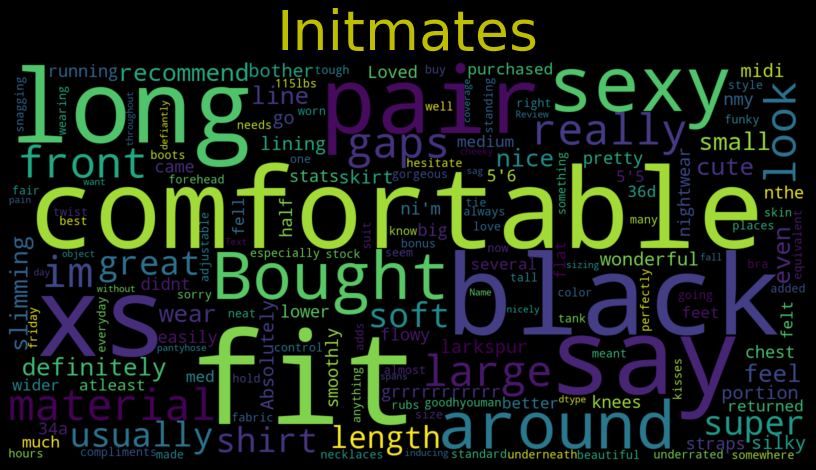

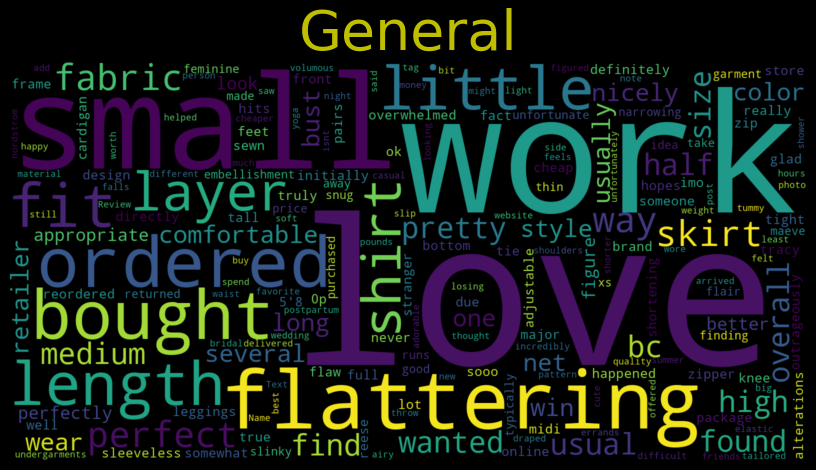

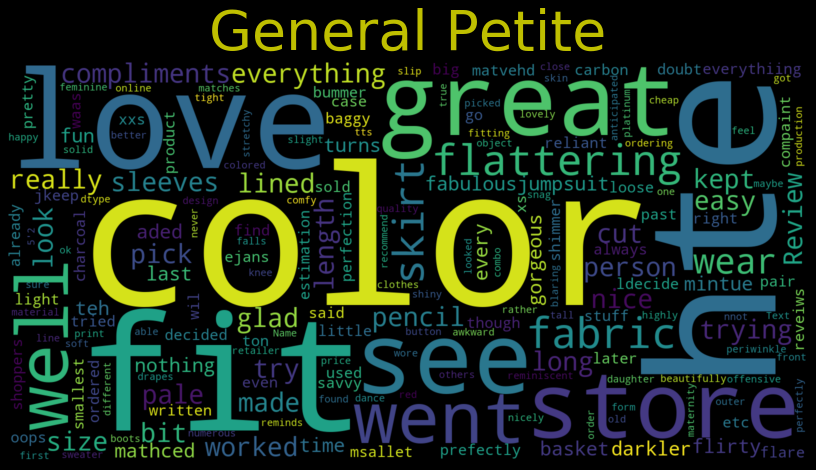

In [27]:
# Plot
cloud_by_category(df, "Division Name", division_set[0])
cloud_by_category(df, "Division Name", division_set[1])
cloud_by_category(df, "Division Name", division_set[2])

A nuvem de palavras mostra apenas a distribuição de palavras individuais dos reviews a partir da analise de sentimento, removendo o contexto onde as palavra estam inseridas o que se torna um problema.

In [147]:
df = df.rename(columns={"Recommended IND": "Recommended"})
df = df.rename(columns={"Review Text": "Review"})
pos_df = df[df.Recommended== 1]
neg_df = df[df.Recommended== 0]
pos_df.head(1)

,Clothing ID,Age,Title,Review,Rating,Recommended,Positive Feedback Count,Division Name,Department Name,Class Name,Word Count,Character Count,Label,Age_rec,Age_2
0,767,31-40,NaN,Absolutely wonderful - silky and sexy and comfortable,4,1,0,Initmates,Intimate,Intimates,8,53,1,31-40,"(25, 35]"


In [148]:
pos_words =[]
neg_words = []

for Review in pos_df.Review:
    pos_words.append(Review) 
pos_words = ' '.join(pos_words)
pos_words[:40]

for Review in neg_df.Review:
    neg_words.append(Review)
neg_words = ' '.join(neg_words)
neg_words[:400]

'I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (ne'

## Positive reviews:

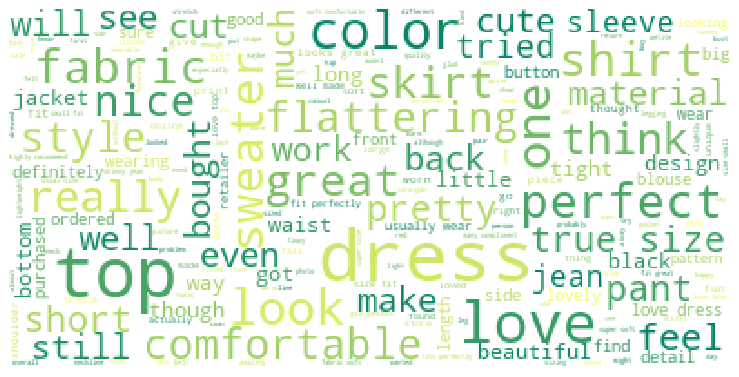

In [154]:
wordcloud = WordCloud().generate(pos_words)

wordcloud = WordCloud(background_color="white",max_words=len(pos_words),\
                      max_font_size=40, relative_scaling=.5, colormap='summer').generate(pos_words)
plt.figure(figsize=(13,13))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Negative Reviews:

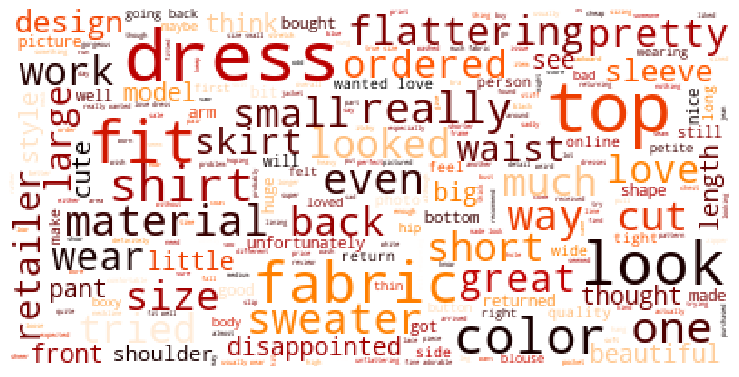

In [155]:
wordcloud = WordCloud().generate(neg_words)

wordcloud = WordCloud(background_color="white",max_words=len(neg_words),\
                      max_font_size=40, relative_scaling=.5, colormap='gist_heat').generate(neg_words)
plt.figure(figsize=(13,13))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Naive Bayes

A análise de sentimentos pode ser feita de várias formas usarei o Algoritmo Naive Bayes de Machine Learning supervisionado. Ele é um classificador probabilístico simples, baseado no teorema de Bayes e utiliza dados de treino para formar um modelo probabilístico baseado na evidência das features no dado.

O Naive Bayes supõe que há uma independência entre as features do modelo. Isso significa que o classificador assume que a presença de uma determinada feature não tem nenhuma relação com outras. No caso de um texto, o classificador assume que as palavras não têm uma relação entre elas, por exemplo, na frase “I love my dog, but today it’s terrible”, o classificador assume que as palavras dessa frase não dependem uma da outra. Sendo assim, essa sentença pode ter uma polaridade positiva, caso a maioria das palavras tenham uma probabilidade maior de serem positivas. É por isso que este tem o nome de “Naive”.

In [28]:
df['tokenized'] = df["Review Text"].astype(str).str.lower() # Turn into lower case text
df['tokenized'] = df.apply(lambda row: tokenizer.tokenize(row['tokenized']), axis=1) # Apply tokenize to each row
df['tokenized'] = df['tokenized'].apply(lambda x: [w for w in x if not w in stop_words]) # Remove stopwords from each row
df['tokenized'] = df['tokenized'].apply(lambda x: [ps.stem(w) for w in x]) # Apply stemming to each row
all_words = nltk.FreqDist(preprocessing(df['Review Text'])) # Calculate word occurrence from whole block of text

vocab_count = 200
word_features= list(all_words.keys())[:vocab_count] # 2000 most recurring unique words
print("Number of words columns (One Hot Encoding): {}".format(len(all_words)))

Number of words columns (One Hot Encoding): 14034


O aprendizado supervisionado requer recursos (variável independente) e um rótulo (variável dependente). Atualmente, a variável independente é o comentário inteiro. No entanto, para que o algoritmo Naïve Bayes funcione, cada palavra deve ser tratada como uma variável. Em vez de utilizar palavras seqüenciais, o modelo observa quais palavras estão presentes em todo o dicionário de palavras disponíveis no corpus de comentários. A função find_features faz exatamente isso, verificando a presença de palavras para um trecho de texto em relação a word_features, uma variável criada anteriormente, que inclui as 5000 palavras mais comuns usadas pelos clientes neste conjunto de dados.

* Variável independente: escolhas de palavras em comentários.
* Variável Dependente: Se a revisão foi ou não recomendada.

In [29]:
# Tupla
labtext= list(zip(df.tokenized, (df["Recommended IND"]))) 

# Função para criar recursos do modelo, para cada revisão, registra quais palavras únicas de todo o corpo do texto estão presentes
def find_features(document):
    words = set(document)
    features = {}
    for w in word_features:
        features[w] = (w in words)

    return features
# Aplicando função aos dados
featuresets = [(find_features(text), LABEL) for (text, LABEL) in labtext]
len(featuresets)

# Train/Test
training_set = featuresets[:15000]
testing_set = featuresets[15000:]

Naive Bayes é um modelo probabilístico que depende do teorema de Bayes para calcular a probabilidade da categoria de uma palavra observando sua ocorrência nas diferentes classes. Uma vez que este modelo analisa boas e más avaliações, é capaz de extrair os tokens de um grama que melhor polarizam as categorias. Usando esse modelo, eu poderia prever o sentimento positivo ou negativo de revisões não rotuladas.
**Como o Naive Bayes funciona?**
O primeiro passo é criar uma tabela de frequência das palavras e suas classes.
Depois calculamos a probabilidade da palavra “love”  por exemplo ser positiva ou negativa.

P(positive|’love’) = P(‘love’|positive) * P(positive) / P(‘love’)
P(negative|’love’) = P(‘love’|negative) * P(negative) / P(‘love’)

Calculando:

P(‘love’|positive) = 3/7 = 0.42 , P(positive) = 7/13 = 0.53, P(‘love’) = 5/13 = 0.3
P(‘love’|negative) = 2/6 = 0.33 , P(negative) =6/13 = 0.46, P(‘love’) = 5/13 = 0.38
Agora, P(positive|’love’) = 0.42 * 0.53 / 0.38 = 0.58

Agora, P(negative|’love’) = 0.33 * 0.46 / 0.38 = 0.39

Veja que a probabilidade da palavra ‘love’ ser positiva é maior do que a probabilidade dela ser negativa.

In [30]:
# Posterior = prior_occurrence * likelihood / evidence
classifier = nltk.NaiveBayesClassifier.train(training_set)

# Saída
print("Classifier accuracy percent:",(nltk.classify.accuracy(classifier, testing_set))*100)
print(classifier.show_most_informative_features(10))

Classifier accuracy percent: 82.48557944415312
Most Informative Features
                   cheap = True                0 : 1      =     12.3 : 1.0
                    glad = True                1 : 0      =      5.4 : 1.0
                  bummer = True                0 : 1      =      5.0 : 1.0
                     net = True                0 : 1      =      4.6 : 1.0
                    idea = True                0 : 1      =      4.4 : 1.0
                  pencil = True                1 : 0      =      4.3 : 1.0
                 perfect = True                1 : 0      =      3.8 : 1.0
                 shimmer = True                1 : 0      =      3.7 : 1.0
                charcoal = True                1 : 0      =      3.7 : 1.0
                     fun = True                1 : 0      =      3.4 : 1.0
None


A primeira coluna exibe as palavras, a segunda representa se a palavra não é recomendada (0: 1) ou é recomendada (1: 0). Por fim, a terceira coluna mostra a proporção de ocorrência. Olhando para a primeira coluna, **“Fun”** é uma palavra recomendada. A precisão deste modelo é de 82%. O poder preditivo de Naive Bayes é limitado em comparação com outros modelos mais complexos.

A recomendação de produto e a classificação do produto são usadas para finalidades diferentes, além de ser um forte indicador de sentimento positivo na revisão.


In [31]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
import scikitplot as skplt
import eli5

Using TensorFlow backend.


In [32]:
vect = TfidfVectorizer()
vect.fit(df["Review Text"])
X = vect.transform(df["Review Text"])

In [33]:
y = df["Recommended IND"].copy()

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.20, random_state=23, stratify=y)

In [34]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
print("Train Set Accuracy: {}".format(metrics.accuracy_score(model.predict(X_train), y_train)))
print("Train Set ROC: {}\n".format(metrics.roc_auc_score(model.predict(X_train), y_train)))

print("Validation Set Accuracy: {}".format(metrics.accuracy_score(model.predict(X_valid), y_valid)))
print("Validation Set ROC: {}".format(metrics.roc_auc_score(model.predict(X_valid), y_valid)))

Train Set Accuracy: 0.9129377969285162
Train Set ROC: 0.8889105042166693

Validation Set Accuracy: 0.8915156871409633
Validation Set ROC: 0.8423407868220376


In [35]:
print(metrics.classification_report(model.predict(X_valid), y_valid))

              precision    recall  f1-score   support

           0       0.56      0.78      0.65       597
           1       0.96      0.91      0.94      3929

    accuracy                           0.89      4526
   macro avg       0.76      0.84      0.79      4526
weighted avg       0.91      0.89      0.90      4526



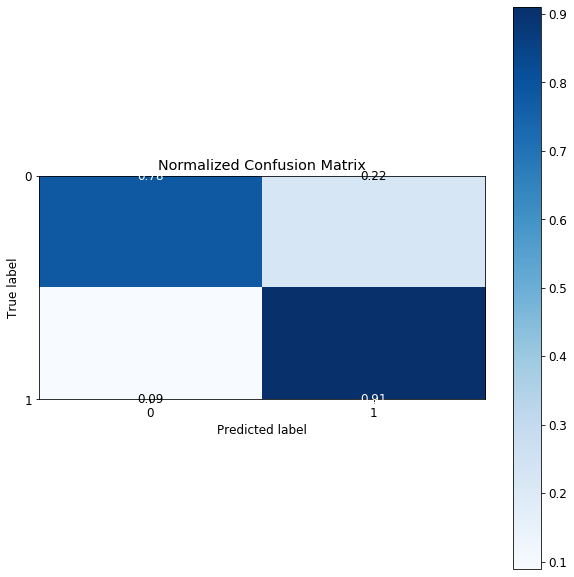

In [36]:
# Matriz de confusão
skplt.metrics.plot_confusion_matrix(model.predict(X_valid), y_valid, normalize=True)
plt.show()

O Modelo acima verifica a acuracia da recomendação, nesse caso de 89%, analisando prla curva ROC que avalia a precisão do modelo com treino de 88% e validação do modelo de 84%.

# ELI5

ELI5 significa literalmente“Explain Like I’m 5”, ou seja, explicar algo para alguém como se ele ou ela tivesse 5 anos de idade.
utilixada para  explicar conceitos complicados de maneira simples e reduzir a confusão e o esforço do cliente, aumentando a lealdade e credibilidade da relação.

In [37]:
target_names = ["Not Recommended","Recommended"]
eli5.show_weights(model, vec=vect, top=20,
                  target_names=target_names)

In [38]:
for iteration in range(5):
    samp = random.randint(1,df.shape[0])
    print("Real Label: {}".format(df["Recommended IND"].iloc[samp]))
    display(eli5.show_prediction(model,df["Review Text"].iloc[samp], vec=vect,
                         target_names=target_names))

Real Label: 1


Real Label: 0


Real Label: 1


Real Label: 0


Real Label: 1


Podemos ver algumas avaliações e como é feito a analise de sentimento para determinar se a avaliação foi positiva ou negativa. É feito um calculo matemático no Naive Bayes, prevendo se a palacvra possui peno negativo ou positivo, aplicando isso para todas as palavras do texto, se o mesmo possuir uma quantidade maior de palavras positivas, a avaliação é positiva, se for negativa a maioria das palavras, a avaliação será negativa. Utilizando o ELI5, podemos visualizar como é feito esse processo, onde o texto possui uma probabilidade de ser pisitivo ou negativo e através da soma dos score comprovamos se a avaliação será positiva ou negativa.